### Import Libraries

In [1]:
import pandas as pd
import numpy as np
import os
from collections import Counter
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter
import geopandas as gpd
import requests
import zipfile
import shutil
from datetime import datetime, timedelta
from google.cloud import bigquery
from google.oauth2 import service_account
import yaml
import imageio
from IPython.display import HTML, display
from geopandas import GeoDataFrame
from shapely import wkt

### Preparation of BigQuery connection parameters

In [2]:
with open('../config.yaml', 'r') as f:
    config = yaml.safe_load(f)

PROJECT_ID = config['PROJECT_ID']
DATASET_NAME = config['DATASET_NAME']
TABLE_NAME = config['TABLE_NAME']
JSON_KEY_BQ = config['JSON_KEY_BQ']

key_path = f"../{JSON_KEY_BQ}"

credentials = service_account.Credentials.from_service_account_file(
    key_path, scopes=["https://www.googleapis.com/auth/cloud-platform"],
)

client = bigquery.Client(credentials=credentials, project=credentials.project_id)

### Establishing the BigQuery connection and downloading from there the data to be analyzed

In [3]:
query = """
SELECT * FROM `airflow_dataset.reporting_results2020`
"""

df = client.query(query).to_dataframe()

### Displaying a sample of downloaded data

In [4]:
df.head()

,id,numer_ewidencyjny_system,numer_ewidencyjny_urzad,data_wplywu_wniosku_do_urzedu,nazwa_organu,wojewodztwo_objekt,obiekt_kod_pocztowy,miasto,terc,cecha,...,kubatura,stan,jednostki_numer,obreb_numer,numer_dzialki,numer_arkusza_dzialki,nazwisko_projektanta,imie_projektanta,projektant_numer_uprawnien,projektant_pozostali
0,<NA>,ST-DL-BO/ZGŁOSZENIE/2669/2023,31376.2023.DG,2023-11-07,Starosta Powiatu Bolesławiec,dolnośląskie,59-700,Bolesławiec,0201011,ul.,...,763.60000000000002,Brak sprzeciwu,020101_1,11,231,None,Polak,Weronika,30/DSOKK/2016,None
1,<NA>,ST-DL-BO/ZGŁOSZENIE/2677/2023,31507.2023.DG,2023-11-08,Starosta Powiatu Bolesławiec,dolnośląskie,59-700,Bolesławiec,0201011,ul.,...,None,Brak sprzeciwu,020101_1,13,93,None,Filipczak,Alina,"5/98/JG, 303/00/DUW",None
2,<NA>,ST-DL-BO/ZGŁOSZENIE/2678/2023,31515.2023.DG,2023-11-08,Starosta Powiatu Bolesławiec,dolnośląskie,59-700,Bolesławiec,0201011,ul.,...,21.780000000000001,Brak sprzeciwu,020101_1,12,237,None,Wójcik,Tomasz,165/DOŚ/12,None
3,<NA>,ST-DL-BO/ZGŁOSZENIE/2679/2023,31584.2023.DG,2023-11-08,Starosta Powiatu Bolesławiec,dolnośląskie,59-700,Bolesławiec,0201011,ul.,...,1,Brak sprzeciwu,020101_1,3,145,None,Polańska,Bożena,LBS/0017/POOS/15,None
4,<NA>,ST-DL-BO/ZGŁOSZENIE/2686/2023,31740.2023.DG,2023-11-09,Starosta Powiatu Bolesławiec,dolnośląskie,59-700,Bolesławiec,0201011,ul.,...,None,Brak sprzeciwu,020101_1,3,201/21,None,Filipczak,Alina,"5/98/JG, 303/00/DUW",None


### Categories of building permits

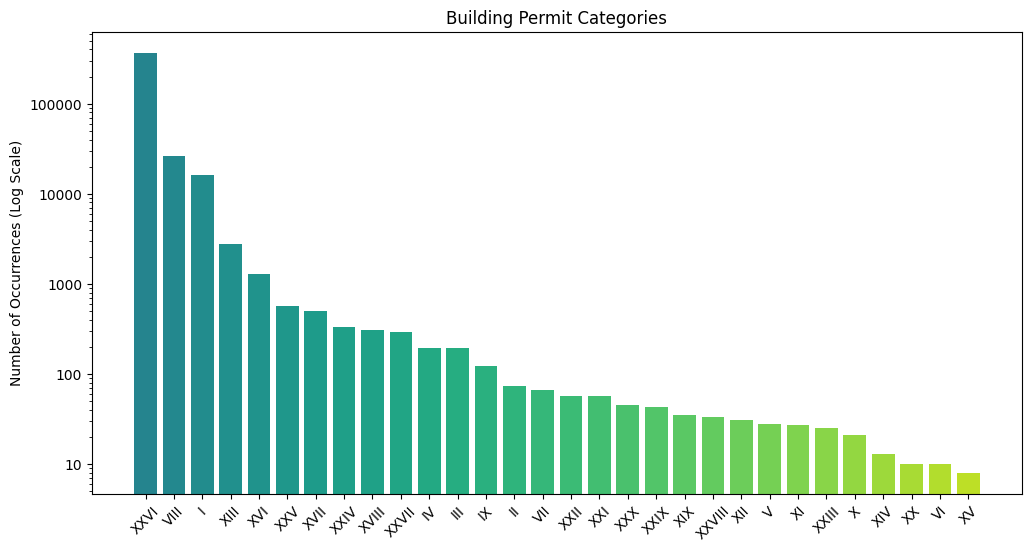

In [5]:
def categories_counter_log(df):
    counter = Counter()
    
    for record in df['kategoria']:
        counter[record] += 1

    # Sorting the data
    sorted_data = dict(sorted(counter.items(), key=lambda x: x[1], reverse=True))

    # Create the plot
    plt.figure(figsize=(12, 6))
    
    # Create color gradient for the plot
    colors = plt.cm.viridis(np.linspace(0.45, 0.9, len(sorted_data)))

    # Plot details
    plt.bar(sorted_data.keys(), sorted_data.values(), color=colors)
    plt.xticks(rotation=45)
    plt.ylabel('Number of Occurrences (Log Scale)')
    plt.title('Building Permit Categories')
    
    # Set Y-axis to logarithmic scale
    plt.yscale('log')

    # Format Y-axis labels as actual numbers instead of powers of 10
    plt.gca().yaxis.set_major_formatter(FuncFormatter(lambda y, _: '{:.0f}'.format(y)))

categories_counter_log(df)


### Names of construction intention type

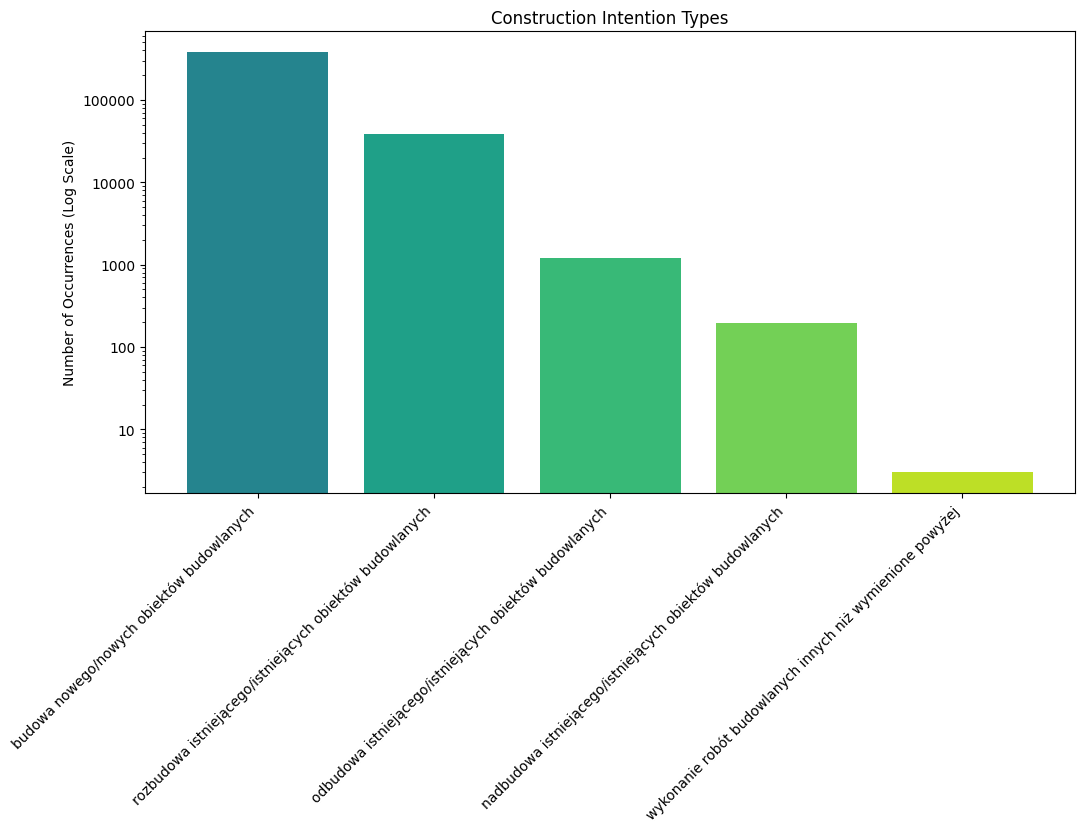

In [6]:
def construction_intention_counter_log(df, column_name):
    counter = Counter()
    
    for record in df[column_name]:
        counter[record] += 1
        
    sorted_data = dict(sorted(counter.items(), key=lambda x: x[1], reverse=True))

    # Create the plot
    plt.figure(figsize=(12, 6))

    # Adjust np.linspace to match the number of categories in sorted_data
    colors = plt.cm.viridis(np.linspace(0.45, 0.9, len(sorted_data)))

    plt.bar(sorted_data.keys(), sorted_data.values(), color=colors)
    plt.xticks(rotation=45, ha='right')  
    plt.ylabel('Number of Occurrences (Log Scale)')
    plt.title('Construction Intention Types')
    plt.yscale('log')
    plt.gca().yaxis.set_major_formatter(FuncFormatter(lambda y, _: '{:.0f}'.format(y)))

    plt.show()

construction_intention_counter_log(df, 'rodzaj_zam_budowlanego')


### Date of receipt of the build application (by month)

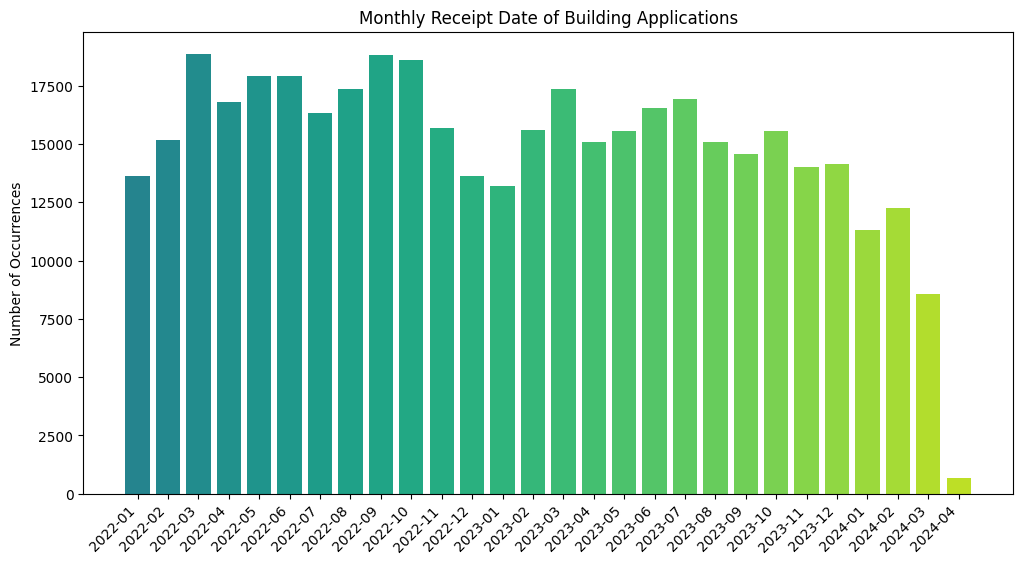

In [7]:
def monthly_receipt_date_counter(df, column_name):
    # Convert column to datetime
    df[column_name] = pd.to_datetime(df[column_name])

    # Group by year and month
    df['YearMonth'] = df[column_name].dt.to_period('M')

    # Count occurrences by month
    counter = Counter(df['YearMonth'])

    # Sort data by date (YearMonth) instead of occurrences
    sorted_data = dict(sorted(counter.items()))

    # Create the plot
    plt.figure(figsize=(12, 6))
    colors = plt.cm.viridis(np.linspace(0.45, 0.9, len(sorted_data)))

    # Convert PeriodIndex to string for plotting
    sorted_keys = [str(key) for key in sorted_data.keys()]
    plt.bar(sorted_keys, sorted_data.values(), color=colors)
    plt.xticks(rotation=45, ha='right')
    plt.ylabel('Number of Occurrences')
    plt.title('Monthly Receipt Date of Building Applications')

    plt.show()

monthly_receipt_date_counter(df, 'data_wplywu_wniosku_do_urzedu')

### Teritorial units downloading

In [8]:
def load_dataframe_from_bigquery():
    # Configure BigQuery client
    client = bigquery.Client(credentials=credentials, project=credentials.project_id)

    # Define your BigQuery project id, dataset id, and table id
    project_id = 'airflow-lab-415614'
    dataset_id = 'airflow_dataset'
    table_id = 'powiaty'

    # Construct the fully-qualified table name
    table_name = f"{project_id}.{dataset_id}.{table_id}"

    # Use the read_gbq function to load the BigQuery data into a DataFrame
    query = f"SELECT * FROM `{table_name}`"
    df_with_powiats = client.query(query).to_dataframe()

    return df_with_powiats

gdf = load_dataframe_from_bigquery()
gdf['geometry'] = gdf['geometry'].apply(wkt.loads)
gdf = gpd.GeoDataFrame(gdf, geometry='geometry')
gdf.crs = "EPSG:4326"
gdf = gdf.to_crs("EPSG:2180")

### Displaying a sample of downloaded teritorial units data

In [9]:
pd.set_option('display.max_columns', None)
gdf.head()

,gml_id,JPT_SJR_KO,JPT_POWIER,JPT_KOD_JE,JPT_NAZWA_,JPT_ORGAN_,JPT_JOR_ID,WERSJA_OD,WERSJA_DO,WAZNY_OD,WAZNY_DO,JPT_KOD__1,JPT_NAZWA1,JPT_ORGAN1,JPT_WAZNA_,ID_BUFORA_,ID_BUFORA1,ID_TECHNIC,IIP_PRZEST,IIP_IDENTY,IIP_WERSJA,JPT_KJ_IIP,JPT_KJ_I_1,JPT_KJ_I_2,JPT_OPIS,JPT_SPS_KO,ID_BUFOR_1,JPT_ID,JPT_POWI_1,JPT_KJ_I_3,JPT_GEOMET,JPT_GEOM_1,SHAPE_LENG,SHAPE_AREA,REGON,RODZAJ,geometry
0,None,POW,77149,1410,powiat łosicki,None,13409,20120926,0,20120926,0,None,None,NZN,NZN,13879,0,829095,PL.PZGIK.200,b83d7094-60a3-460b-b308-f7ec80abb622,2012-09-27T08:13:53+02:00,EGIB,1410,None,None,UZG,0,829095,0,None,0,0,2.22022741319,.10159508736,03023735100000,powiat,"POLYGON ((753920.175 497017.076, 753918.822 49..."
1,None,POW,85222,1427,powiat sierpecki,None,13409,20120926,0,20120926,0,None,None,NZN,NZN,13879,0,829112,PL.PZGIK.200,0be630fb-6221-441d-ae7e-a47db756834b,2012-09-27T08:13:53+02:00,EGIB,1427,None,None,UZG,0,829112,0,None,0,0,2.13891769559,.11359410242,61101616900000,powiat,"POLYGON ((534236.749 555932.727, 534235.027 55..."
2,None,POW,61483,1404,powiat gostyniński,None,13409,20120926,0,20120926,0,None,None,NZN,NZN,13879,0,829121,PL.PZGIK.200,e7dfba34-48fe-4274-9cb0-abcc6ff01654,2012-09-27T08:13:53+02:00,EGIB,1404,None,None,UZG,0,829121,0,None,0,0,2.43577119369,.08114292243,61101610000000,powiat,"POLYGON ((542005.402 491528.247, 542006.073 49..."
3,None,POW,36652,1405,powiat grodziski,None,13409,20120926,0,20120926,0,None,None,NZN,NZN,13879,0,829122,PL.PZGIK.200,5c1e181f-3b0f-46f6-8c94-8610f98e8e1b,2012-09-27T08:13:53+02:00,EGIB,1405,None,None,UZG,0,829122,0,None,0,0,1.92348148982,.04811360215,01326910800000,powiat,"POLYGON ((616605.919 475446.071, 616609.405 47..."
4,None,POW,11055,1463,powiat Radom,None,13409,20120926,0,20120926,0,None,None,NZN,NZN,13879,0,829134,PL.PZGIK.200,50972166-aed4-4508-adc3-a716723228d1,2012-09-27T08:13:53+02:00,EGIB,1463,None,None,UZG,0,829134,0,None,0,0,.78166267311,.01444107549,67022311000000,powiat,"POLYGON ((652810.687 389173.149, 652792.489 38..."


### Adding a dictionary with mappings of voivodeship codes to voivodeship names

In [10]:
voivodeships = {
    '02': 'Lower Silesian',
    '04': 'Kuyavian-Pomeranian',
    '06': 'Lublin',
    '08': 'Lubusz',
    '10': 'Lodz',
    '12': 'Lower Poland',
    '14': 'Masovian',
    '16': 'Opole',
    '18': 'Podkarpackie',
    '20': 'Podlaskie',
    '22': 'Pomeranian',
    '24': 'Silesian',
    '26': 'Swietokrzyskie',
    '28': 'Warmian-Masurian',
    '30': 'Greater Poland',
    '32': 'West Pomeranian',
}

### Plots with building application per voivodship from last 3,2 and 1 month. Also, the plots map visualisation under each related plot.

/tmp/ipykernel_81/1744488564.py:41: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['voivodeship'] = df[data_column].apply(lambda x: x[:2] if isinstance(x, str) else 'Unknown')
/opt/conda/lib/python3.11/site-packages/geopandas/plotting.py:48: ShapelyDeprecationWarning: The 'type' attribute is deprecated, and will be removed in the future. You can use the 'geom_type' attribute instead.
  if geom is not None and geom.type.startswith(prefix) and not geom.is_empty:


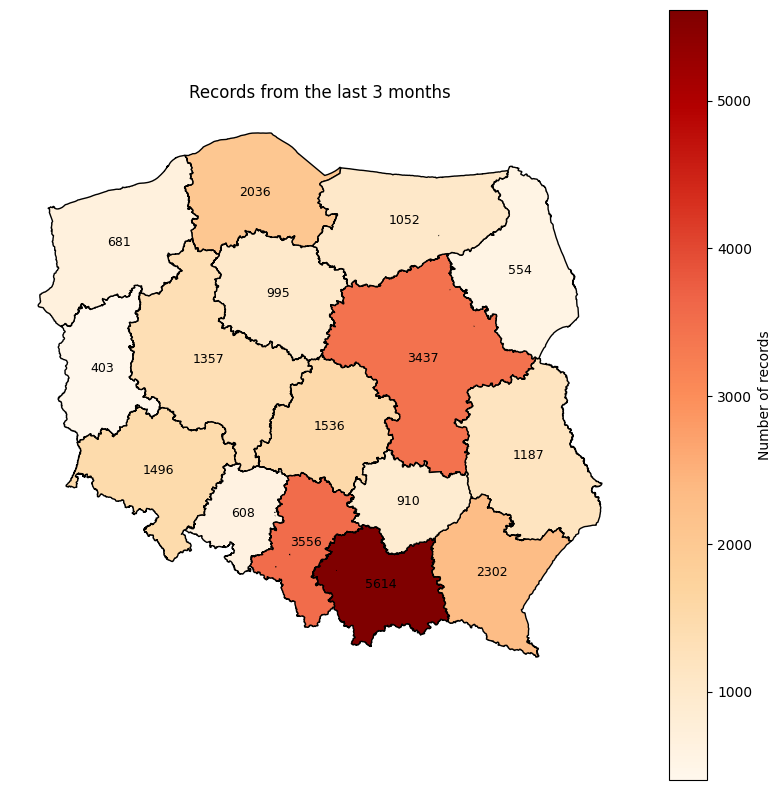

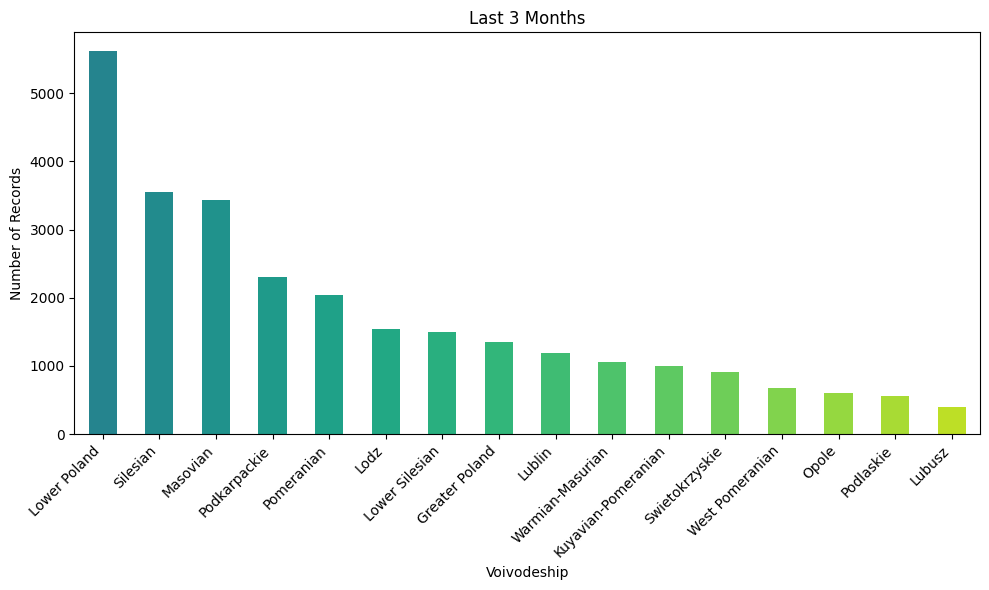

/tmp/ipykernel_81/1744488564.py:41: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['voivodeship'] = df[data_column].apply(lambda x: x[:2] if isinstance(x, str) else 'Unknown')
/opt/conda/lib/python3.11/site-packages/geopandas/plotting.py:48: ShapelyDeprecationWarning: The 'type' attribute is deprecated, and will be removed in the future. You can use the 'geom_type' attribute instead.
  if geom is not None and geom.type.startswith(prefix) and not geom.is_empty:


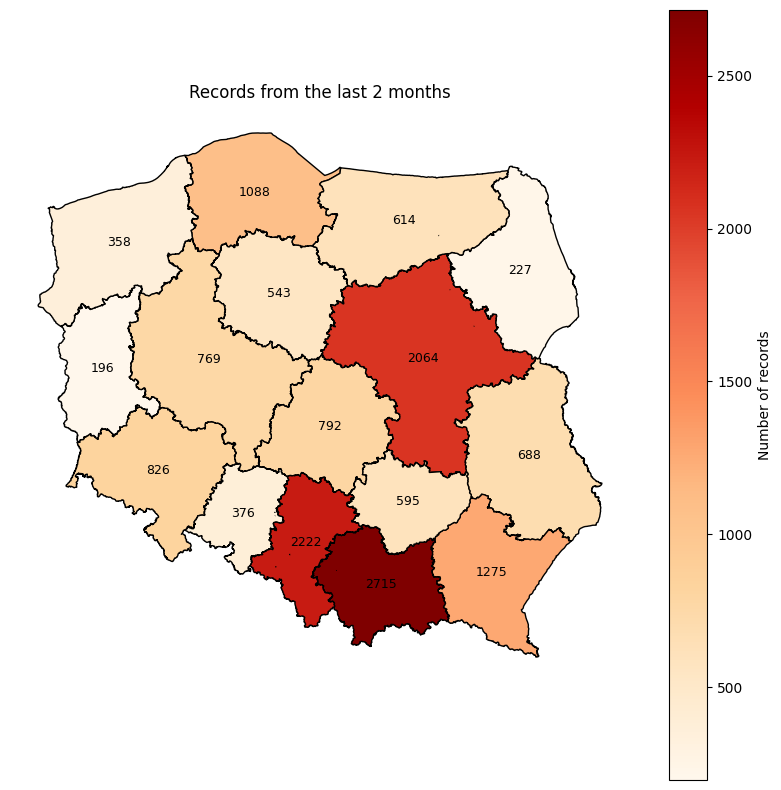

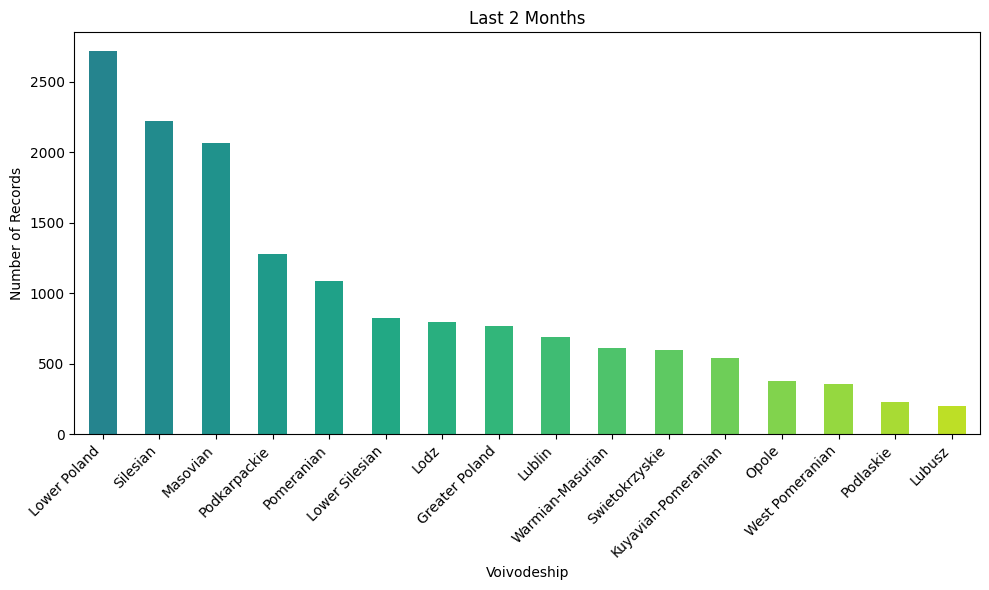

/tmp/ipykernel_81/1744488564.py:41: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['voivodeship'] = df[data_column].apply(lambda x: x[:2] if isinstance(x, str) else 'Unknown')
/opt/conda/lib/python3.11/site-packages/geopandas/plotting.py:48: ShapelyDeprecationWarning: The 'type' attribute is deprecated, and will be removed in the future. You can use the 'geom_type' attribute instead.
  if geom is not None and geom.type.startswith(prefix) and not geom.is_empty:


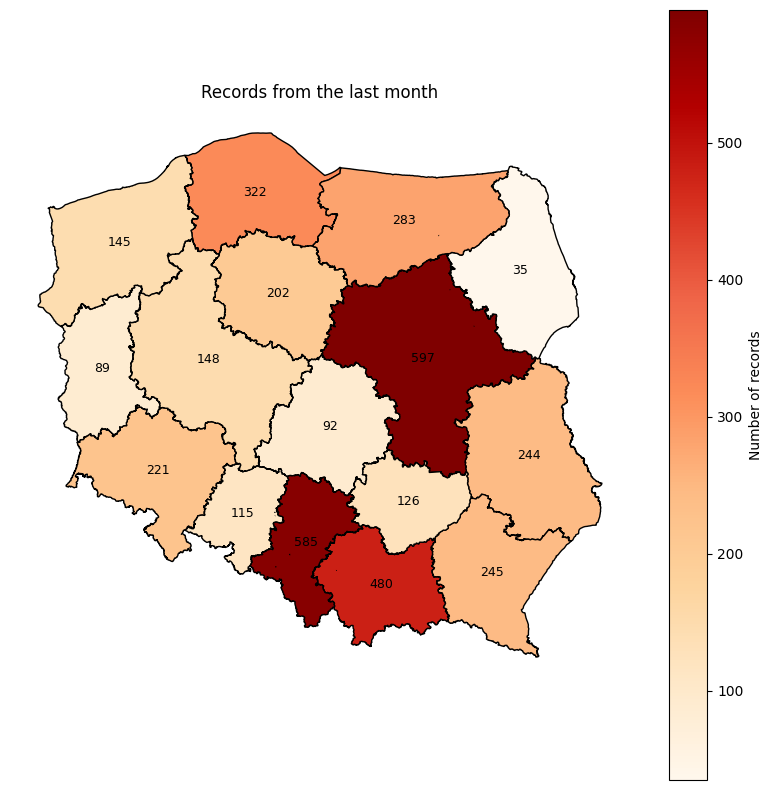

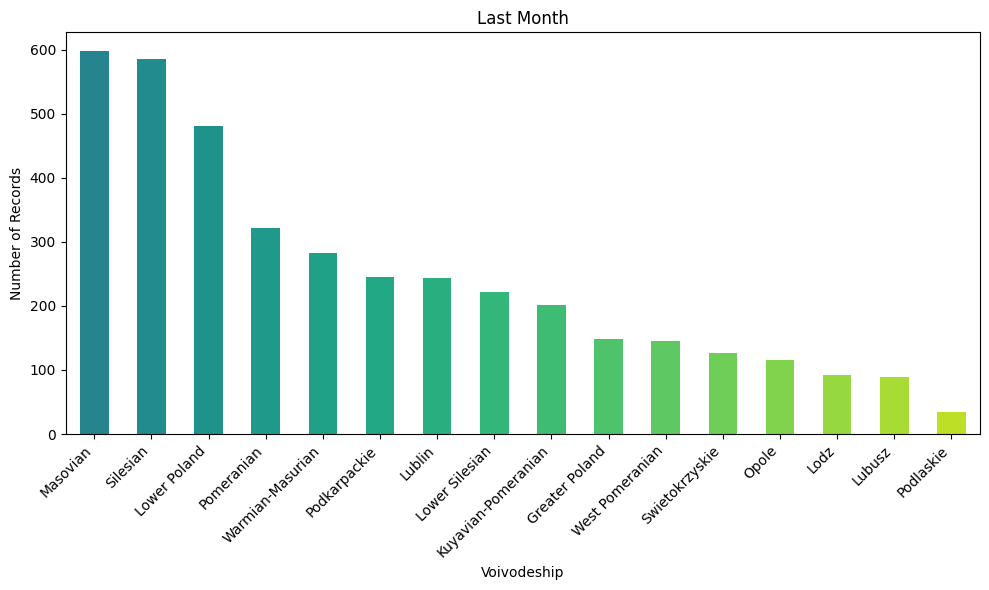

In [12]:
# Convert the 'data_wplywu_wniosku_do_urzedu' column to datetime objects
df['data_wplywu_wniosku_do_urzedu'] = pd.to_datetime(df['data_wplywu_wniosku_do_urzedu'])

# Define the end date (latest date in the data)
end_date = df['data_wplywu_wniosku_do_urzedu'].max()

# Calculate the start dates for three time periods (3 months, 2 months, 1 month)
three_months_ago = end_date - timedelta(days=90)
two_months_ago = end_date - timedelta(days=60)
one_month_ago = end_date - timedelta(days=30)

# Filter the data for each time period
df_three_months = df[df['data_wplywu_wniosku_do_urzedu'] >= three_months_ago]
df_two_months = df[df['data_wplywu_wniosku_do_urzedu'] >= two_months_ago]
df_one_month = df[df['data_wplywu_wniosku_do_urzedu'] >= one_month_ago]

def generate_plot(data, title):
    # Extract the first two digits from 'terc_code' and calculate counts
    voivodeship_counts = data['terc'].apply(lambda x: voivodeships.get(x[:2], 'Unknown') if isinstance(x, str) else 'Unknown').value_counts()

    # Limit the counts to the first 16 entries
    voivodeship_counts = voivodeship_counts.head(16)  # Ogranicza do pierwszych 16 województw

    # Use viridis color palette
    colors = plt.cm.viridis(np.linspace(0.45, 0.9, len(voivodeship_counts)))

    plt.figure(figsize=(10, 6))
    voivodeship_counts.plot(kind='bar', color=colors)
    plt.title(title)
    plt.xlabel('Voivodeship')
    plt.ylabel('Number of Records')
    #Voivodeships' names as X axis labels
    plt.xticks(range(len(voivodeship_counts)), voivodeship_counts.index, rotation=45, ha='right')
    plt.tight_layout()
    plt.show()

from shapely.ops import unary_union

def visualize_voivodeships_from_powiats(df, powiaty_map, title, data_column='terc'):
    #Change the powiats' names to voivodeships' names in the Dataframe
    df['voivodeship'] = df[data_column].apply(lambda x: x[:2] if isinstance(x, str) else 'Unknown')

    #Summary of all voivodeships' data
    summary = df['voivodeship'].value_counts().rename_axis('voivodeship').reset_index(name='counts')

    #Group the powiats' map by voivodeships
    powiaty_map['voivodeship'] = powiaty_map['JPT_KOD_JE'].str[:2]  #Let's say that 2 first characters of powiat codes are voivodeship code
    voivodeship_map = powiaty_map.dissolve(by='voivodeship')  #Add up the powiats to the voivodeships

    #Attach the data summary to the voivodeships' map 
    merged_map = voivodeship_map.merge(summary, left_on='voivodeship', right_on='voivodeship', how='left')

    #Set the missing values as 0
    merged_map['counts'] = merged_map['counts'].fillna(0)

    # Creating the map
    fig, ax = plt.subplots(1, 1, figsize=(10, 10))
    merged_map.plot(column='counts', ax=ax, legend=True,
                    legend_kwds={'label': "Number of records"},
                    cmap='OrRd', edgecolor='black')

    #Adding all the labels for each voivodeship
    for idx, row in merged_map.iterrows():
        # Drawing the voivodeships' centroid
        centroid = row.geometry.centroid
        plt.text(centroid.x, centroid.y, str(int(row['counts'])), ha='center', va='center', fontsize=9)

    ax.set_axis_off()

    # Add the title
    plt.title(title)

    # Show the map
    plt.show()

# call the functions
powiaty_map = gpd.GeoDataFrame(gdf, geometry='geometry')
visualize_voivodeships_from_powiats(df_three_months, powiaty_map, 'Records from the last 3 months')
generate_plot(df_three_months, 'Last 3 Months')
visualize_voivodeships_from_powiats(df_two_months, powiaty_map, 'Records from the last 2 months')
generate_plot(df_two_months, 'Last 2 Months')
visualize_voivodeships_from_powiats(df_one_month, powiaty_map, 'Records from the last month')
generate_plot(df_one_month, 'Last Month')

### Plots with building application per example voivodship of Masovian per powiat from last 3,2 and 1 month

/opt/conda/lib/python3.11/site-packages/geopandas/plotting.py:48: ShapelyDeprecationWarning: The 'type' attribute is deprecated, and will be removed in the future. You can use the 'geom_type' attribute instead.
  if geom is not None and geom.type.startswith(prefix) and not geom.is_empty:


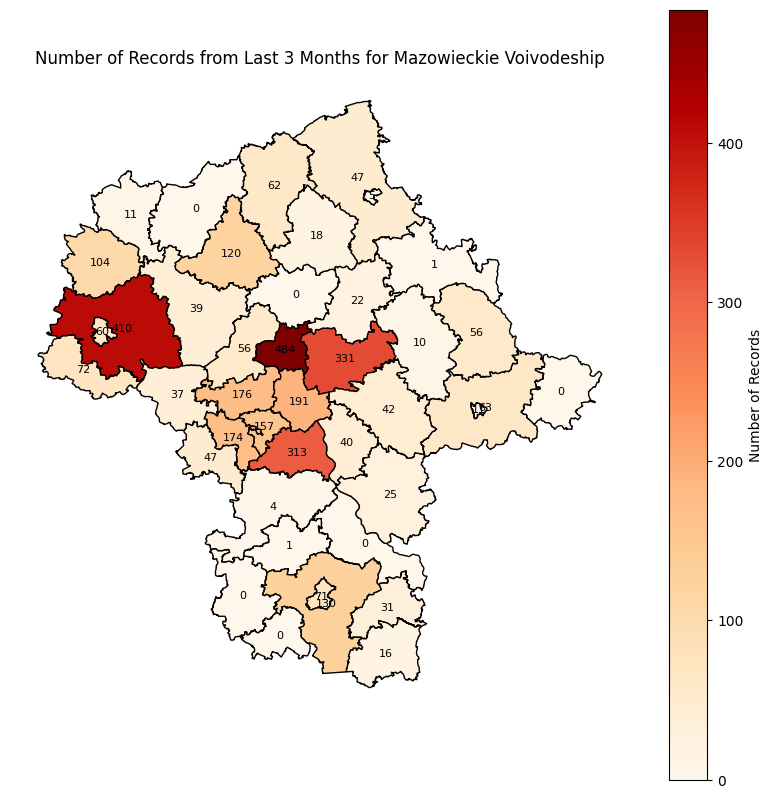

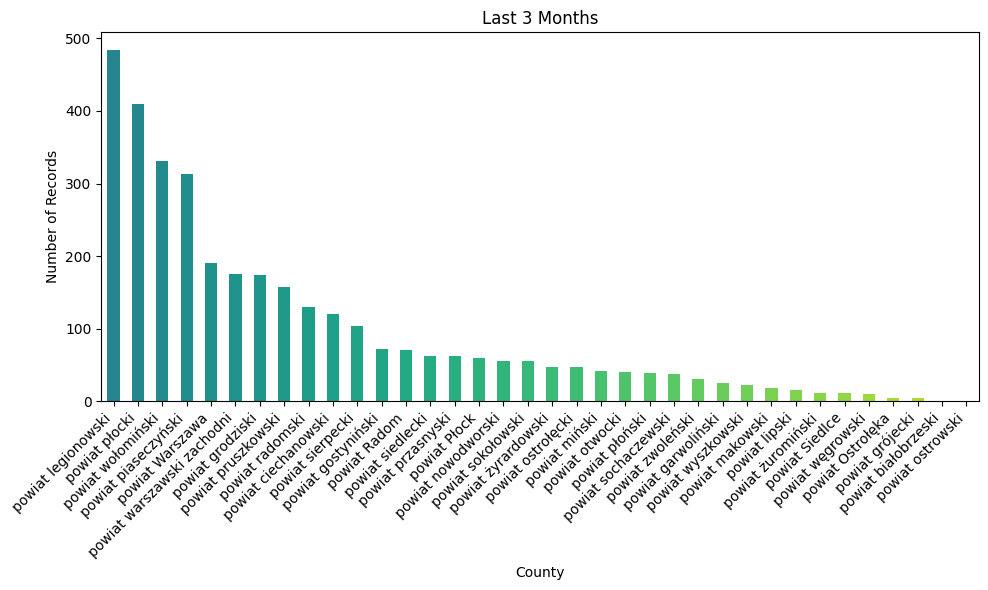

/opt/conda/lib/python3.11/site-packages/geopandas/plotting.py:48: ShapelyDeprecationWarning: The 'type' attribute is deprecated, and will be removed in the future. You can use the 'geom_type' attribute instead.
  if geom is not None and geom.type.startswith(prefix) and not geom.is_empty:


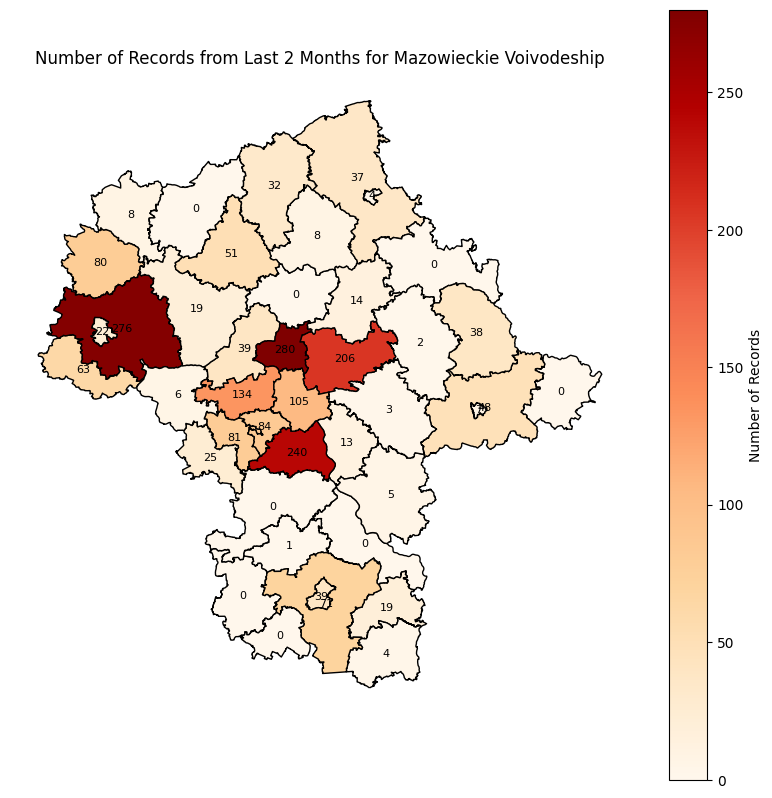

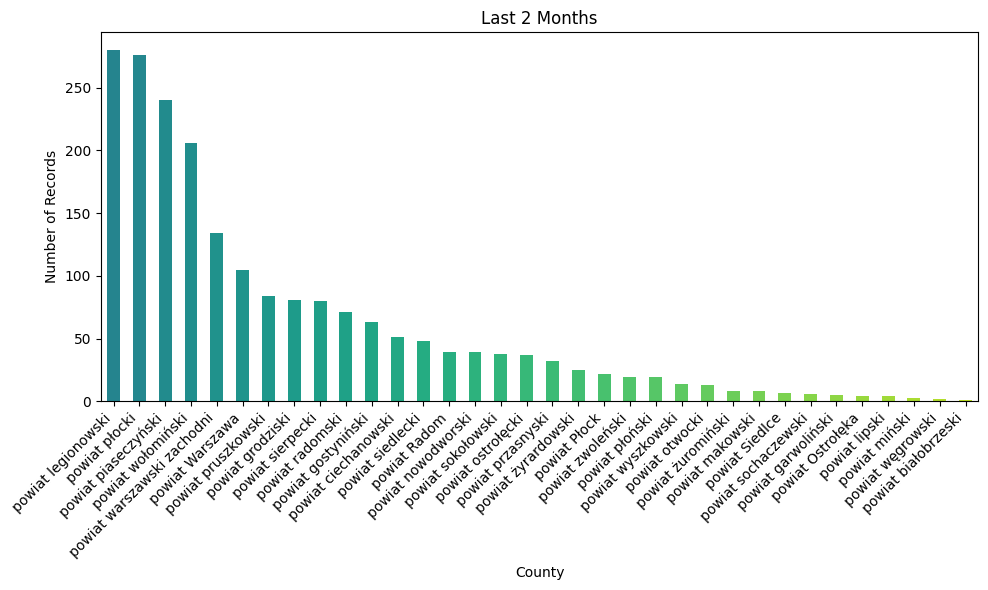

/opt/conda/lib/python3.11/site-packages/geopandas/plotting.py:48: ShapelyDeprecationWarning: The 'type' attribute is deprecated, and will be removed in the future. You can use the 'geom_type' attribute instead.
  if geom is not None and geom.type.startswith(prefix) and not geom.is_empty:


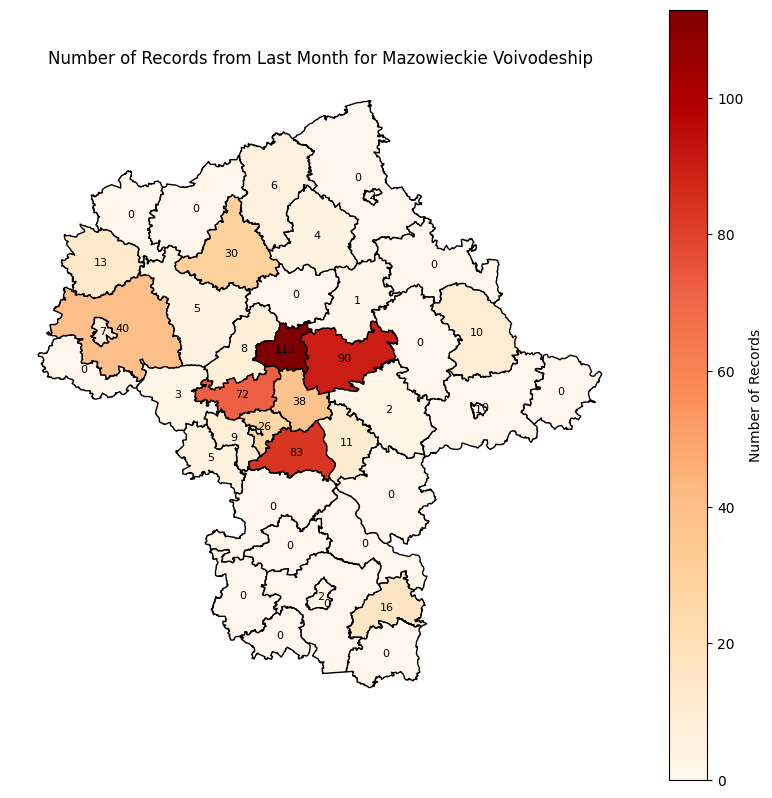

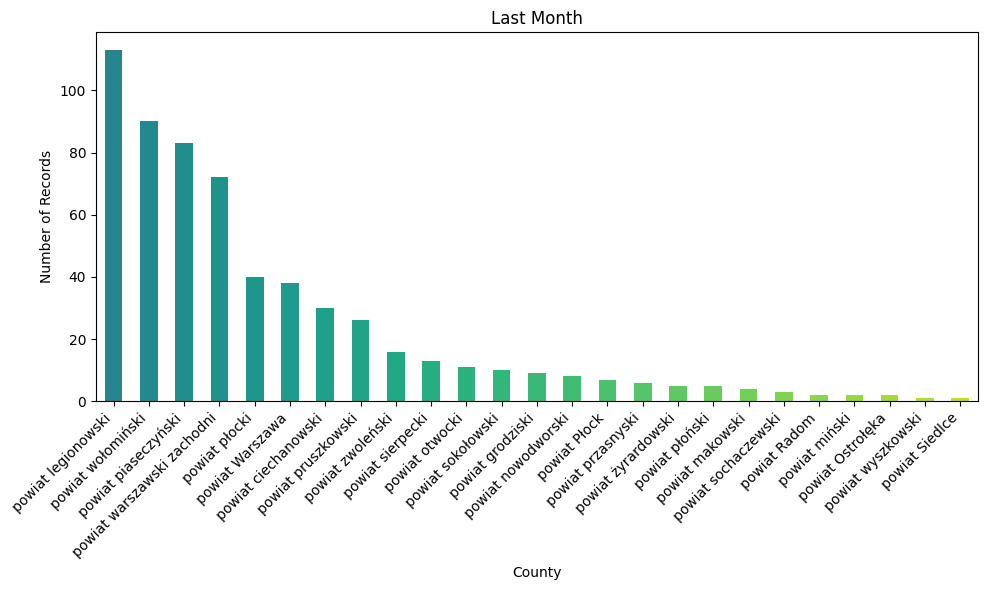

In [13]:
def generate_plot_powiat(data, gdf, title):
    # Filter data to contain only records with 'terc' codes starting with '14'
    filtered_data = data[data['terc'].apply(lambda x: str(x).startswith('14') if isinstance(x, str) else False)]

    # Calculate counts for each county in the voivodeship (first four digits from 'terc_code')
    powiat_counts = filtered_data['terc'].apply(lambda x: x[:4] if isinstance(x, str) else 'Unknown').value_counts()

    # Replace county codes with names using direct lookup in gdf
    powiat_labels = [gdf[gdf['JPT_KOD_JE'] == code]['JPT_NAZWA_'].iloc[0] if (gdf['JPT_KOD_JE'] == code).any() else 'Unknown' for code in powiat_counts.index]

    # Use viridis color palette
    colors = plt.cm.viridis(np.linspace(0.45, 0.9, len(powiat_counts)))

    plt.figure(figsize=(10, 6))
    powiat_counts.plot(kind='bar', color=colors)
    plt.title(title)
    plt.xlabel('County')
    plt.ylabel('Number of Records')
    # Set county names as X-axis labels
    plt.xticks(range(len(powiat_counts)), powiat_labels, rotation=45, ha='right')
    plt.tight_layout()
    plt.show()

def visualize_powiats_mazowieckie(df, powiaty_map, title, data_column='terc'):
    # Filter data to contain only records from Mazowieckie voivodeship
    filtered_data = df[df[data_column].apply(lambda x: str(x).startswith('14') if isinstance(x, str) else False)]

    # Summarize data for each county
    summary = filtered_data[data_column].apply(lambda x: x[:4] if isinstance(x, str) else 'Unknown').value_counts().rename_axis('county').reset_index(name='counts')

    # Filter county map to contain only those from Mazowieckie voivodeship
    mazowieckie_powiats_map = powiaty_map[powiaty_map['JPT_KOD_JE'].str.startswith('14')]

    # Merge data summary into county map
    merged_map = mazowieckie_powiats_map.merge(summary, left_on='JPT_KOD_JE', right_on='county', how='left')

    # Set missing values to 0
    merged_map['counts'] = merged_map['counts'].fillna(0)

    # Plot the map
    fig, ax = plt.subplots(1, 1, figsize=(10, 10))
    merged_map.plot(column='counts', ax=ax, legend=True,
                    legend_kwds={'label': "Number of Records"},
                    cmap='OrRd', edgecolor='black')

    # Add value labels for each county
    for idx, row in merged_map.iterrows():
        # Get centroid of each county
        centroid = row.geometry.centroid
        plt.text(centroid.x, centroid.y, str(int(row['counts'])), ha='center', va='center', fontsize=8)

    # Remove axes for cleaner look
    ax.set_axis_off()

    # Add title
    plt.title(title)

    # Display the map
    plt.show()

# Example function calls
powiaty_map = gpd.GeoDataFrame(gdf, geometry='geometry')  # Load county map
visualize_powiats_mazowieckie(df_three_months, powiaty_map, 'Number of Records from Last 3 Months for Mazowieckie Voivodeship')
generate_plot_powiat(df_three_months, gdf, 'Last 3 Months')
visualize_powiats_mazowieckie(df_two_months, powiaty_map, 'Number of Records from Last 2 Months for Mazowieckie Voivodeship')
generate_plot_powiat(df_two_months, gdf, 'Last 2 Months')
visualize_powiats_mazowieckie(df_one_month, powiaty_map, 'Number of Records from Last Month for Mazowieckie Voivodeship')
generate_plot_powiat(df_one_month, gdf, 'Last Month')


### GIF file comparing the changes between the voivodeships between last 3 months combined, 2 months combined and the last month

In [14]:
from PIL import Image, ImageDraw

# Function to save voivodeship maps as PNG with a consistent size and DPI
def save_voivodeship_maps_as_png(df, powiaty_map, title, data_column='terc'):
    df = df.copy()
    df.loc[:, 'voivodeship'] = df[data_column].apply(lambda x: x[:2] if isinstance(x, str) else 'Unknown')
    summary = df['voivodeship'].value_counts().rename_axis('voivodeship').reset_index(name='counts')
    powiaty_map['voivodeship'] = powiaty_map['JPT_KOD_JE'].str[:2]
    voivodeship_map = powiaty_map.dissolve(by='voivodeship')
    merged_map = voivodeship_map.merge(summary, left_on='voivodeship', right_on='voivodeship', how='left')
    merged_map['counts'] = merged_map['counts'].fillna(0)
    fig, ax = plt.subplots(1, 1, figsize=(10, 10))
    # Set the same color scale for all maps: vmin=0, vmax=40000
    merged_map.plot(column='counts', ax=ax, legend=True, legend_kwds={'label': "Number of Records by Voivodeship"}, 
                    cmap='OrRd', edgecolor='black', vmin=0, vmax=30000)
    for idx, row in merged_map.iterrows():
        centroid = row.geometry.centroid
        plt.text(centroid.x, centroid.y, str(int(row['counts'])), ha='center', va='center', fontsize=9)
    ax.set_axis_off()
    plt.title(title)
    file_path = f'map_{title.replace(" ", "_")}.png'
    plt.savefig(file_path, bbox_inches='tight')
    plt.close()
    return file_path
    
# Example usage with placeholder data and file paths
df['terc'] = df['terc'].apply(lambda x: str(x))
powiaty_map = gpd.GeoDataFrame(gdf, geometry='geometry')

# Filtering data and generating maps with consistent dimensions
end_date = df['data_wplywu_wniosku_do_urzedu'].max()
periods = [(90, 'Building permissions per voivodship from the last 3 months'), (60, 'Building permissions per voivodship from the last 2 months'), (30, 'Building permissions per voivodship from the last month')]
filenames = []

for days, title in periods:
    start_date = end_date - timedelta(days=days)
    filtered_df = df[df['data_wplywu_wniosku_do_urzedu'] >= start_date]
    filename = save_voivodeship_maps_as_png(filtered_df, powiaty_map, title)
    filenames.append(filename)

# Load map images into a list, making sure they all have the same resolution and color mode
common_size = (800, 600)  # Adjust this size as needed
images = []
for filename in filenames:
    if os.path.exists(filename):
        img = Image.open(filename).convert('RGBA')  # Convert all images to the same color mode
        img = img.resize(common_size)  # Ensure all images have the same resolution
        images.append(img)
    else:
        print(f'File {filename} not found')

# Continue only if we have loaded images
if images:
    # Save the map images as a GIF with each frame lasting 2.5 seconds
    images[0].save('voivodeships.gif', save_all=True, append_images=images[1:], duration=2500, loop=0)

    # Delete the temporary map files
    for filename in filenames:
        os.remove(filename)

# Display the resulting GIF
display(HTML(f"<img src='voivodeships.gif' width='800'>"))


/opt/conda/lib/python3.11/site-packages/geopandas/plotting.py:48: ShapelyDeprecationWarning: The 'type' attribute is deprecated, and will be removed in the future. You can use the 'geom_type' attribute instead.
  if geom is not None and geom.type.startswith(prefix) and not geom.is_empty:
/opt/conda/lib/python3.11/site-packages/geopandas/plotting.py:48: ShapelyDeprecationWarning: The 'type' attribute is deprecated, and will be removed in the future. You can use the 'geom_type' attribute instead.
  if geom is not None and geom.type.startswith(prefix) and not geom.is_empty:
/opt/conda/lib/python3.11/site-packages/geopandas/plotting.py:48: ShapelyDeprecationWarning: The 'type' attribute is deprecated, and will be removed in the future. You can use the 'geom_type' attribute instead.
  if geom is not None and geom.type.startswith(prefix) and not geom.is_empty:
